CS512 - Computer Vision - Assignment 4 Question 2

Submitted by-

Tushar Gwal A20449419

# Question 2: Object Detection

In [1]:
# Importing required libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.models import load_model

# Part 1: Loading Dataset and Computing Bounding Boxes from Segmentation Masks

In [2]:
# Loading Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', split='test', with_info=True)
img = next(iter(dataset))     # an image from dataset

# funtion to extract image and segmentation mask from dataset image
def extract_img(x):
    image = x['image']
    mask = x['segmentation_mask']  # Assuming the mask is available in the sample
    return image.numpy(), mask.numpy()

# function to Preprocess image for YOLO compatibility
def preprocess_img(image, target_size=(416, 416)):
    res_img = tf.image.resize(image, target_size).numpy()
    norm_img = res_img.astype('float32') / 255.0
    exp_img = np.expand_dims(norm_img, axis=0)
    return exp_img

# funtion to get bounding box from the segmentation mask
def get_bounding_box(segmentation_mask):
    pet_pixels = np.argwhere(segmentation_mask > 0)
    if pet_pixels.size == 0:
        return None
    ymin = np.min(pet_pixels[:, 0])
    ymax = np.max(pet_pixels[:, 0])
    xmin = np.min(pet_pixels[:, 1])
    xmax = np.max(pet_pixels[:, 1])
    return xmin, ymin, xmax, ymax

# Extracting an image and its segmentation mask from the dataset
im, sm = extract_img(img)

# Preprocess the image for YOLO input
inp_img = preprocess_img(im)

# Part 2. Loading the YOLO Model and Using Its Functions

a. Loading the model

In [3]:
# Loading pre-trained YOLOv3 model from a Keras .h5 file
model = load_model('/content/yolo.h5')
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
labels = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase"
]  # taken few labels only


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


b. Yolo Utility Functions

* Please note: these are predefined yolo utility functions taken from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

* However i have tweaked few function as per the requirement

In [4]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

# Decode network output into bounding boxes
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []

    netout[..., :2] = _sigmoid(netout[..., :2])
    netout[..., 4:] = _sigmoid(netout[..., 4:])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h * grid_w):
        row = i // grid_w
        col = i % grid_w
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if objectness.all() <= obj_thresh:
                continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w
            y = (row + y) / grid_h
            w = anchors[2 * b + 0] * np.exp(w) / net_w
            h = anchors[2 * b + 1] * np.exp(h) / net_h
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
            boxes.append(box)
    return boxes

# Utility function to calculate interval overlap
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

# Calculate the Intersection over Union (IoU) between two bounding boxes
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union_area = w1 * h1 + w2 * h2 - intersect_area
    return intersect_area / union_area if union_area > 0 else 0

def iou(b1, b2):
    x1, y1, x2, y2 = b1
    xp1, yp1, xp2, yp2 = b2

    inter_x1 = max(x1, xp1)
    inter_y1 = max(y1, yp1)
    inter_x2 = min(x2, xp2)
    inter_y2 = min(y2, yp2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area_b1 = (x2 - x1) * (y2 - y1)
    area_b2 = (xp2 - xp1) * (yp2 - yp1)
    union_area = area_b1 + area_b2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

# Correct bounding boxes
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    for box in boxes:
        box.xmin = int((box.xmin) * image_w)
        box.xmax = int((box.xmax) * image_w)
        box.ymin = int((box.ymin) * image_h)
        box.ymax = int((box.ymax) * image_h)

# Non-max suppression to filter overlapping boxes
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0:
                continue
            for j in range(i + 1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0


# Get valid bounding boxes with labels and confidence scores
def get_boxes(boxes, labels, thresh, pet_boxes):
    v_boxes, v_labels, v_scores = list(), list(), list()

    pet_boxes = get_bounding_box(sm)
    if pet_boxes is not None:
        xmin, ymin, xmax, ymax = pet_boxes
        v_boxes.append(BoundBox(xmin, ymin, xmax, ymax, 1.0, np.array([1, 0])))
        v_labels.append("pet")
        v_scores.append(100.0)

    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i] * 100)

    return v_boxes, v_labels, v_scores

# Function to draw bounding boxes with labels and confidence scores
def draw_boxes(image, v_boxes, v_labels, v_scores, pet_boxes=None):
    plt.imshow(image)
    ax = plt.gca()

# Draw bounding boxes from YOLO detections
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='white')
        ax.add_patch(rect)
        label = f"{v_labels[i]} ({v_scores[i]:.3f})"
        plt.text(x1, y1, label, color='white')

# Draw bounding boxes from segmentation masks
    if pet_boxes:
        for box in pet_boxes:
            if box is None:
                continue
            xmin, ymin, xmax, ymax = box
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')  # Red color for pet boxes
            ax.add_patch(rect)
            plt.text(xmin, ymin, "Pet", color='red')

    plt.show()

# Part 3 : Testing the model by passing an image from oxford_iiit_pet dataset and displaying the result

a. Using YOLO model on dataset image

In [5]:

m = model.predict(inp_img)
boxes = []
class_threshold = 0.6
input_w, input_h = 416, 416

for i in range(len(m)):
    boxes += decode_netout(m[i][0], anchors[i], class_threshold, input_h, input_w)

image_h, image_w = im.shape[:2]
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
do_nms(boxes, 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


b. Displaying the results

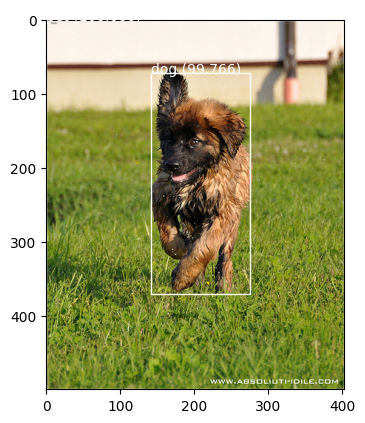

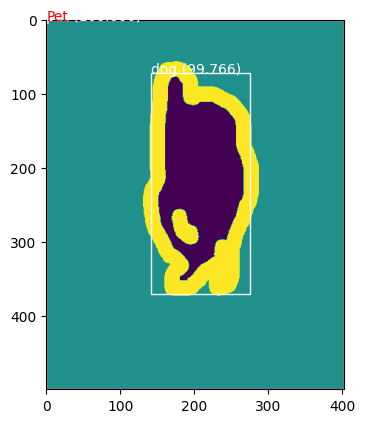

In [6]:
# Drawing bounding boxes on the original image with labels and confidence
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold, sm)
draw_boxes(im / 255.0, v_boxes, v_labels, v_scores)

# Drawing the segmentation mask with bounding boxes
sb = get_bounding_box(sm)
draw_boxes(sm, v_boxes, v_labels, v_scores, pet_boxes=[sb])

# Part 4: Evaluation

In [7]:
#function to load annotation from both the files
def load_ann(path, pred=False):
    anns = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            name = parts[0]
            bbox = parts[1].split(',')
            if pred:
                coords = list(map(float, bbox[:4]))
                label = int(bbox[4])
                conf = float(bbox[5])
                anns[name] = (coords, label, conf)
            else:
                coords = list(map(int, bbox[:4]))
                label = int(bbox[4])
                anns[name] = (coords, label)
    return anns

# function to calculate True positive, False Positive, False Negative, precision, recall, map
def calc_map(gt, preds, iou_thresh=[0.25, 0.5, 0.75, 0.95]):
    ap = {0: [], 1: [], 'overall': []}
    print("\nMetrics:")
    print(f"GT samples: {len(gt)}")
    print(f"Predictions: {len(preds)}")
    print(f"IoU thresholds: {iou_thresh}")
    invalid_labels = set()
    for _, (_, label, _) in preds.items():
        if label not in [0, 1]:
            invalid_labels.add(label)
    if invalid_labels:
        print(f"Ignoring Invalid labels in predictions: {invalid_labels}")
    for t in iou_thresh:
        stats = {0: {'tp': 0, 'fp': 0, 'fn': 0}, 1: {'tp': 0, 'fp': 0, 'fn': 0}}
        scores = {0: [], 1: []}
        for name, gt_info in gt.items():
            gt_box, gt_label = gt_info
            if name in preds:
                pred_box, pred_label, conf = preds[name]
                if pred_label not in [0, 1]:
                    stats[gt_label]['fn'] += 1
                    continue
                iou_val = iou(gt_box, pred_box)
                if gt_label == pred_label and iou_val >= t:
                    stats[gt_label]['tp'] += 1
                    scores[gt_label].append((conf, 1))
                else:
                    stats[gt_label]['fn'] += 1
                    stats[pred_label]['fp'] += 1
                    scores[pred_label].append((conf, 0))
            else:
                stats[gt_label]['fn'] += 1
        for cls in [0, 1, 'overall']:
            cls_scores = scores[0] + scores[1] if cls == 'overall' else scores[cls]
            cls_scores.sort(key=lambda x: x[0], reverse=True)
            tp = 0
            fp = 0
            prec_list = []
            rec_list = []
            for _, is_tp in cls_scores:
                if is_tp:
                    tp += 1
                else:
                    fp += 1
                prec = tp / (tp + fp) if (tp + fp) > 0 else 0
                rec = tp / (stats[cls]['tp'] + stats[cls]['fn']) if cls != 'overall' else tp / sum(stats[c]['tp'] + stats[c]['fn'] for c in [0, 1])
                prec_list.append(prec)
                rec_list.append(rec)
            ap_score = 0
            for i in range(len(prec_list)):
                if i == 0 or rec_list[i] != rec_list[i - 1]:
                    ap_score += prec_list[i] * (rec_list[i] - rec_list[i - 1] if i > 0 else rec_list[i])
            ap[cls].append(ap_score)
        print(f"\nIoU {t}:")
        for cls in [0, 1]:
            print(f"  Class {cls}:")
            print(f"    TP: {stats[cls]['tp']}")
            print(f"    FP: {stats[cls]['fp']}")
            print(f"    FN: {stats[cls]['fn']}")
            prec = stats[cls]['tp'] / (stats[cls]['tp'] + stats[cls]['fp']) if (stats[cls]['tp'] + stats[cls]['fp']) > 0 else 0
            rec = stats[cls]['tp'] / (stats[cls]['tp'] + stats[cls]['fn']) if (stats[cls]['tp'] + stats[cls]['fn']) > 0 else 0
            print(f"    Precision: {prec:.4f}")
            print(f"    Recall: {rec:.4f}")
            print(f"    AP: {ap[cls][-1]:.4f}")
        print(f"  MAP: {ap['overall'][-1]:.4f}")

# loading the ground truth label and preditcion labels txt file
gt = load_ann('/content/gt_label.txt')
preds = load_ann('/content/pred_label.txt', pred=True)

# calling the function
calc_map(gt, preds)


Metrics:
GT samples: 3662
Predictions: 3484
IoU thresholds: [0.25, 0.5, 0.75, 0.95]
Ignoring Invalid labels in predictions: {2, 3, 4, 6, 7, 8, 10, 14, 17, 24, 30, 40, 41, 42, 43, 44, 47, 48, 50, 51, 52, 58, -15, -13, -2, -5, -1}

IoU 0.25:
  Class 0:
    TP: 1028
    FP: 7
    FN: 153
    Precision: 0.9932
    Recall: 0.8704
    AP: 0.8690
  Class 1:
    TP: 2234
    FP: 59
    FN: 247
    Precision: 0.9743
    Recall: 0.9004
    AP: 0.8981
  MAP: 0.8886

IoU 0.5:
  Class 0:
    TP: 1023
    FP: 12
    FN: 158
    Precision: 0.9884
    Recall: 0.8662
    AP: 0.8623
  Class 1:
    TP: 2192
    FP: 101
    FN: 289
    Precision: 0.9560
    Recall: 0.8835
    AP: 0.8633
  MAP: 0.8616

IoU 0.75:
  Class 0:
    TP: 890
    FP: 145
    FN: 291
    Precision: 0.8599
    Recall: 0.7536
    AP: 0.6699
  Class 1:
    TP: 2000
    FP: 293
    FN: 481
    Precision: 0.8722
    Recall: 0.8061
    AP: 0.7375
  MAP: 0.7182

IoU 0.95:
  Class 0:
    TP: 27
    FP: 1008
    FN: 1154
    Precision: 0.0